**Оценка результатов A/B-теста**

**Цель исследования** — провести оценку результатов A/B-теста, оценить корректность его проведения, проанализировать результаты теста.

**Ход исследования**
1. Загрузка данных.
2. Подготовка данных:
    - Ознакомление с данными.
    - Преобразование типов данных.
    - Анализ пропусков в дубликатов.
3. Оценка корректности проведения теста по следующим параметрам: 
    - Соответствие данных требованиям технического задания.
    - Время проведения теста. 
    - Аудитория теста (нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно, проверка равномерности распределения по тестовым группам и правильность их формирования).
4. Исследовательский анализ данных:
    - Расчет количества событий на пользователя, распределение показателя в выборках.
    - Распределение числа событий в выборках по дням.
    - Изменения конверсии в воронке в выборках на разных этапах.
    - Особенности A/B-тестирования.
5. Оценка результатов A/B-тестирования:
    - Какие результаты показало A/В-тестирование?
    - Проверка статистической разницы долей z-критерием.
6. Вывод, общее заключение о корректности проведения теста.


**Техническое задание**
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.


# **1. Загрузка данных**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime, timedelta
import scipy.stats as stats
import plotly.express as px
from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest


In [2]:
import plotly.io as pio 
pio.renderers.default = "png" 
svg_renderer = pio.renderers["png"] 
svg_renderer.scale = 1.2

In [3]:
try:
    events = pd.read_csv('C:/Users/user/Desktop/Проект/final_ab_events.csv')
    marketing_events = pd.read_csv('C:/Users/user/Desktop/Проект/ab_project_marketing_events.csv')
    new_users = pd.read_csv('C:/Users/user/Desktop/Проект/final_ab_new_users.csv')
    participants = pd.read_csv('C:/Users/user/Desktop/Проект/final_ab_participants.csv')
       
except:
    events = pd.read_csv('/datasets/final_ab_events.csv')
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')

# **2. Подготовка данных**
## **2.1 Ознакомление с данными**

In [4]:
display(events.head())
events.info()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


В таблице events находится информация о действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.  
Таблица содержит 440317 строк с информацией о id пользователя, дате и названии события, столбец с дополнительной информацией.    В столбце 'details' содержатся пропуски.   
'event_dt' нужно привести к формату даты.

In [5]:
display(marketing_events.head())
marketing_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Представляет собой  календарь маркетинговых событий на 2020 год.
Таблица содержит информацию о маркетинговых событиях: их названии, регионе и времени проведения. В талице 14 строк, пропущенных значений нет.  
Данные в колонках 'start_dt' и 'finish_dt' необходимо привести к формату даты.

In [6]:
display(new_users.head())
new_users.info()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


Таблица содержит информацию о пользователях, зарегистрировавшиеся с 7 до 21 декабря 2020 года. Представлены данные о пользовавателях, такие как id пользователя, дата регистрации, регион регистрации и устройство, с которого произошла регистрация пользователя.  
В таблице 61733 строки, пропущенных значений нет.
'first_date' нужно привести к формату даты.

In [7]:
display(participants.head())
participants.info()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


таблица участников тестов. Содержит такую информация об участниках теста: идентификатор пользователя, группа пользователя и название теста.
В таблице 18268 строк, пропущенных значений не выявлено, типы данных корректны.

## **2.2 Преобразование типов данных**

В прошлом пункте работы выяснили, что во всех таблицах столбцы, содержащие информацию о времени (дате) необходимо привнести к формату даты.

In [8]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [9]:
display(events.info())

display(marketing_events.info())

new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


## **2.3 Анализ пропусков в дубликатов**

In [10]:
# проверка на явные дубликаты
print('Кол-во дубликатов', events.duplicated().sum())
print('Кол-во дубликатов', marketing_events.duplicated().sum())
print('Кол-во дубликатов', new_users.duplicated().sum())
print('Кол-во дубликатов', participants.duplicated().sum())

Кол-во дубликатов 0
Кол-во дубликатов 0
Кол-во дубликатов 0
Кол-во дубликатов 0


Дубликатов в данных не найдено.

В таблице 'events' есть пропуски.

In [11]:
events.isnull().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [12]:
pd.DataFrame(round(events.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
event_dt,0.000000
event_name,0.000000
details,86.000000


В столбце 'details' таблицы 'events' содержится 86% пропусков. Рассмотрим их подробнее.

In [13]:
events.groupby('event_name').count()

,user_id,event_dt,details
event_name,,,
login,189552,189552,0
product_cart,62462,62462,0
product_page,125563,125563,0
purchase,62740,62740,62740


In [14]:
events.query('event_name=="purchase"')

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
62735,1455450835F72F5E,2020-12-30 09:27:10,purchase,4.99
62736,339C4C55021A83C6,2020-12-30 12:55:08,purchase,9.99
62737,D1553B56FFA8974B,2020-12-30 03:15:35,purchase,4.99
62738,245E85F65C358E08,2020-12-30 19:35:55,purchase,9.99


Данные в столбце details есть только для события purchase. В остальных столбцах пропуски. Скорее всего этот столбец заполняется именно на этапе покупки. В нем содержится информация о стоимости покупки. 

В данном случае пропуски заполнять нецелесообразно.

# 3 **Оценка корректности проведения теста по следующим параметрам:** 
## 3.1 **Соответствие данных требованиям технического задания**

Проверим, соответствует ли аудитория проведения теста представленному ТЗ. Объединим таблица участников тестов с таблицей с данными пользователей, указанных при регистрации и таблицей с действиями пользователей.

In [15]:
# объединенная таблица участников тестов
df = participants.merge(new_users, on='user_id', how='left').merge(events, on='user_id', how='left')
df

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
...,...,...,...,...,...,...,...,...,...
110363,63FBE257B05F2245,A,interface_eu_test,2020-12-20,EU,Android,2020-12-23 13:03:17,login,NaN
110364,79F9ABFB029CF724,B,interface_eu_test,2020-12-14,EU,PC,2020-12-14 19:12:49,login,NaN
110365,79F9ABFB029CF724,B,interface_eu_test,2020-12-14,EU,PC,2020-12-15 01:50:22,login,NaN
110366,79F9ABFB029CF724,B,interface_eu_test,2020-12-14,EU,PC,2020-12-16 19:27:36,login,NaN


Проверим, сколько человек приняло участие в тесте.

In [16]:
print('Количество участников теста:', 
      df.query('ab_test == "recommender_system_test"')['user_id'].nunique())

Количество участников теста: 6701


In [17]:
df.query('ab_test == "recommender_system_test"').groupby('group')['user_id'].nunique()

group
A    3824
B    2877
Name: user_id, dtype: int64

В тесте recommender_system_test приняли участие 6701 человек, разделенные на 2 группы.

Проверим, совпадают ли периоды привлечения новых пользователей и время проведения теста.

In [18]:
print('Новые пользователи привлечены в период с {} по {}.'.format(
    df.query('ab_test == "recommender_system_test"')['first_date'].min(),
    df.query('ab_test == "recommender_system_test"')['first_date'].max()))
print()
# максимальное и минимальное время событий в датасете
print('Минимальное время совершения событий', df.query('ab_test == "recommender_system_test"')['event_dt'].min())
print('Максимальное время совершения событий', df.query('ab_test == "recommender_system_test"')['event_dt'].max())

Новые пользователи привлечены в период с 2020-12-07 00:00:00 по 2020-12-21 00:00:00.

Минимальное время совершения событий 2020-12-07 00:05:57
Максимальное время совершения событий 2020-12-30 12:42:57


Дата запуска теста совпадает с ТЗ: 2020-12-07;  
Дата остановки набора новых пользователей: по ТЗ - 2020-12-21, совпадает с ТЗ;  
Дата остановки теста: по ТЗ - 2021-01-04, по факту - 2020-12-30.  
Возможно, не все пользователи имели возможность совершить события в первые 14 дней после регистрации. Это может негативно сказаться на результатах тестирования.

Проверим долю пользователей из Европы, попавших в тест.

In [19]:
print('Доля пользователей из Европы, участвующих в тесте:', round(
    df.query('ab_test == "recommender_system_test" and region == "EU"')['user_id'].nunique() / 
    new_users.query('first_date >= "2020-12-07" and first_date <= "2020-12-21" & region == "EU"')['user_id'].nunique()*100, 2), '%')


Доля пользователей из Европы, участвующих в тесте: 15.0 %


В тесте приняли участие только 15 % новых пользователя из Европы.

## 3.2 **Время проведения теста**

Проверим, что время проведения теста не совпадает с маркетинговыми и другими активностями.

In [20]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [21]:
# Найдем список маркетинговый событий, которые окончились до даты начала регистрацции новых пользователей.
mark = marketing_events.loc[marketing_events['finish_dt']<"2020-12-07"]
mark = list(mark['name'])

# удалим этот список из списка маркетинговых событий
mark1 = marketing_events.query('name not in @mark')

# отффильтруем по региону
mark1 = mark1[mark1['regions'].str.contains("EU")]
mark1

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Во время теста в регионе EU была запущена новогодняя акция.Это могло сказаться на результатах теста.

## 3.3 **Аудитория теста**

Проверим, есть ли пересечения с конкурирующим тестом и есть ли пользователи, участвующие в двух группах теста одновременно.

In [22]:
# подсчитаем, в скольки группах состоит каждый из пользователей теста recommender_system_test
v = df.query('ab_test=="recommender_system_test"').groupby('user_id')['group'].nunique()
# подсчитаем, сколько пользователей попали в обе группы
v.reset_index().query('group > 1').count()

user_id    0
group      0
dtype: int64

Пересечений пользователей групп А и В теста recommender_system_test не выявлено.

In [23]:
a = df.groupby('user_id')['ab_test'].nunique()
a.reset_index().query('ab_test > 1').count()

user_id    1602
ab_test    1602
dtype: int64

1602 человека участвовали одновременно в двух тестах. Это может повлиять на результаты тестирования, если пользователи одновременно попали в группы А (в одном из тестов) и В (в другом тесте). Проверим это.

In [24]:
# найдем пересечения пользователей групп А recommender_system_test и группы В interface_eu_test
a_t1_b_t2=list(set(df.query('ab_test == "recommender_system_test" and group == "A"').user_id) & 
                     set(df.query('ab_test == "interface_eu_test" and group == "B"').user_id))
# найдем пересечения пользователей групп В recommender_system_test и группы В interface_eu_test
b_t1_t2 = list(set(df.query('ab_test == "recommender_system_test" and group == "B"').user_id) & 
                     set(df.query('ab_test == "interface_eu_test" and group == "B"').user_id))   

In [25]:
print(len(a_t1_b_t2))
print(len(b_t1_t2))

439
344


Таких пользователей нашлось 783 человека. Создадим новый df_new, в который войдут участники recommender_system_test, за исключением пересекающихся с конкурирующим тестом. 

In [26]:
df_new = df.query('user_id != @b_t1_t2 and user_id != @a_t1_b_t2 and ab_test =="recommender_system_test"')
df_new

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
...,...,...,...,...,...,...,...,...,...
27719,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-07 10:12:15,login,NaN
27720,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-08 22:51:16,login,NaN
27721,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-09 02:28:03,login,NaN
27722,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-10 22:55:14,login,NaN


In [27]:
df_new = df_new.query('region=="EU"')
df_new

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
...,...,...,...,...,...,...,...,...,...
26285,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:06,product_page,NaN
26286,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-20 20:01:34,product_page,NaN
26287,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-14 05:48:50,login,NaN
26288,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:03,login,NaN


По условиям ТЗ сроки теста - 14 дней, поэтому необходимо отфильтровать события, которые пользователи совершили после 14 дней от регистрации.

In [28]:
#добавление столбца lifetime - сколько времени прошло от даты регистрации до совершенного события
df_new['lifetime'] = df_new['event_dt'] - df_new['first_date']
df_new['lifetime']=df_new['lifetime'].dt.days

# срез по параметрам ТЗ
last_events=df_new[df_new['lifetime']>14].index.to_list()
df_new= df_new.query('index != @last_events')

#преобразование типа 
#df_new['lifetime']=df_new['lifetime'].dt.round(freq = 'D')
print('Число участников теста после фильтрации событий:', df_new['user_id'].nunique())

Число участников теста после фильтрации событий: 5568


C:\Users\user\AppData\Local\Temp\ipykernel_14276\3304922994.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_14276\3304922994.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Проверим, соответствует ли время привлечения пользователей ТЗ.

In [29]:
print('Новые пользователи привлечены в период с {} по {}.'.format(
    df_new['first_date'].min(),
    df_new['first_date'].max()))
print()
# максимальное и минимальное время событий в датасете
print('Минимальное время совершения событий', df_new['event_dt'].min())
print('Максимальное время совершения событий', df_new['event_dt'].max())

Новые пользователи привлечены в период с 2020-12-07 00:00:00 по 2020-12-21 00:00:00.

Минимальное время совершения событий 2020-12-07 00:05:57
Максимальное время совершения событий 2020-12-29 23:38:29


Время привлечения новых пользователей соответствует ТЗ, а время окончания теста - 2020-12-29, возможно пользователи не совершали действий после указанной даты.

In [30]:
print('Доля пользователей из Европы, участвующих в тесте:', round(
    df_new['user_id'].nunique() / 
    new_users['user_id'].nunique()*100, 2), '%')

Доля пользователей из Европы, участвующих в тесте: 9.02 %


In [31]:
df_new.groupby('group')['user_id'].nunique()

group
A    3195
B    2373
Name: user_id, dtype: int64

In [32]:
(df_new.groupby('group')['user_id'].nunique()/df_new['user_id'].nunique()*100).round(2)

group
A    57.38
B    42.62
Name: user_id, dtype: float64

In [33]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22552 entries, 0 to 26289
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     22552 non-null  object        
 1   group       22552 non-null  object        
 2   ab_test     22552 non-null  object        
 3   first_date  22552 non-null  datetime64[ns]
 4   region      22552 non-null  object        
 5   device      22552 non-null  object        
 6   event_dt    20034 non-null  datetime64[ns]
 7   event_name  20034 non-null  object        
 8   details     2736 non-null   float64       
 9   lifetime    20034 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 1.9+ MB


В полученной таблице имеются пропуски в столбцах event_dt и event_name. Предполагаю, что некоторые из привлеченных и зарегистрированных пользователей не совершали никаких действий во время тестирования. Пока не будем удалять данные об этих пользователях.

По результатам фильтрации в тесте остались 5568 человек, из которых 57.38% попали в группу А, 42.62% - в группу В. Временные интервалы совпадают с ТЗ, доля новых пользователей из Европы, участвующих в тесте составила 9.02 %.

## 3.4 Промежуточный вывод по результатам оценки корректности проведения теста

По результатам оценки корректности проведения теста, его совпадению с ТЗ выявлено:
- сроки набора новых пользователей в группы теста отличаются от ТЗ.
- срок окончания теста раньше заявленного в ТЗ. Тест закончился 2020-12-30 18:28:55 - последнее совершенное событие у пользователей, вместо ожидаемого 2021-01-04. Возможно привлеченные пользователи перестали совершать действия, отражающиеся в результатах теста.
- в тест было набрано 6701 человек вместо 6000 человек.
- время проведения теста совпадает с новогодней маркетинговой акцией. В этот момент возможно аномальное поведение пользователей.

В результате анализа состава участников теста выявлено 
- пересечение пользователей теста recommender_system_test и конкурирующего теста interface_eu_test, 
- события, совершенные свыше чем через 14 дней от даты регистрации пользователей и 
- пользователи из разных регионов, не только Европы.

По результатам фильтрации в тесте остались 5568 человек, из которых 57.38% попали в группу А, 42.62% - в группу В. Временные интервалы совпадают с ТЗ, доля пользователей из Европы, участвующих в тесте составила 9,02 %.


# 4. **Исследовательский анализ данных**
## 4.1 **Расчет количества событий на пользователя, распределение показателя в выборках**


Посмотрим сколько в среднем событий приходится на одного пользователя в каждой из групп.

In [34]:
# распределение всех событий по группам теста
df_new.group.value_counts() 

A    16767
B     5785
Name: group, dtype: int64

In [35]:
# количество сообытий по уникальным пользователям
ab_events = (df_new.pivot_table(index='group', aggfunc={'event_dt': 'count', 'user_id': 'nunique'})
             .rename(columns = {'event_dt': 'count_events', 'user_id': 'qty_users'}))

# определим количество событий на каждого пользователя в группах
ab_events['events_per_user'] = round(ab_events['count_events'] / ab_events['qty_users'], 2)

ab_events

,count_events,qty_users,events_per_user
group,,,
A,15851,3195,4.96
B,4183,2373,1.76


Распределение событий в группе неравномерное. В группе А событий значительно больше, но и участников в группе больше. В среднем, на участника группы А приходится 4,96 события, в группе В - 1,76 события.

Посмотрим, как распределены события в группах в зависимости от типа события. 

In [36]:
df_new.groupby('group')['user_id'].nunique()

group
A    3195
B    2373
Name: user_id, dtype: int64

In [37]:
groups = df_new.pivot_table(index = ['event_name', 'group'], values = 'user_id', aggfunc = 'count')

groups['mean'] = round(groups['user_id']/df_new.groupby('group')['user_id'].nunique(), 2)
groups = groups.reset_index()
groups

,event_name,group,user_id,mean
0,login,A,7018,2.20
1,login,B,2036,0.86
2,product_cart,A,2114,0.66
3,product_cart,B,542,0.23
4,product_page,A,4514,1.41
5,product_page,B,1074,0.45
6,purchase,A,2205,0.69
7,purchase,B,531,0.22


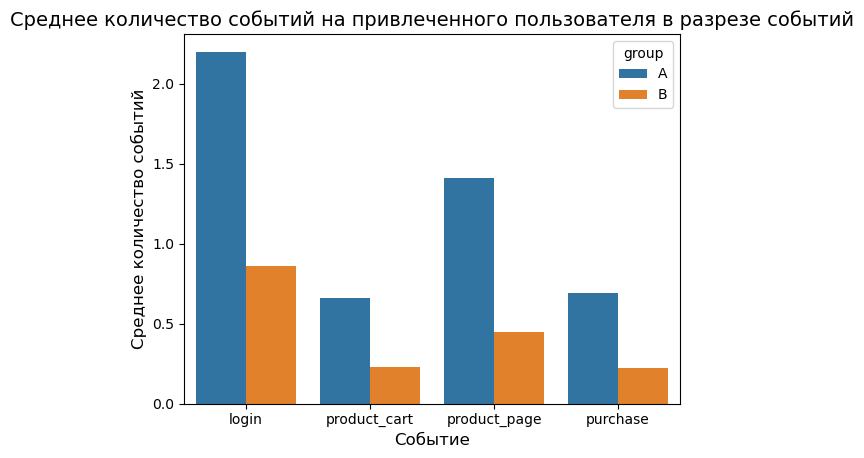

In [38]:
sns.barplot(x='event_name', y='mean', data=groups, hue='group')
plt.title(label = "Среднее количество событий на привлеченного пользователя в разрезе событий", fontsize = 14)
plt.ylabel('Среднее количество событий',  fontsize = 12)
plt.xlabel('Событие', size = 12)
plt.show(); 

В группе А большее количество событий на пользователя приходится по всем событиям. Посмотрим на графики распределения.

In [39]:
# сводная таблица сколько пользователей совершили события
group_event= df_new.groupby(['user_id', 'group'])['event_name'].count().reset_index()
group_event=group_event.groupby(['group', 'event_name'])['user_id'].count().reset_index()
group_event

,group,event_name,user_id
0,A,0,916
1,A,1,28
2,A,2,173
3,A,3,204
4,A,4,384
5,A,5,36
6,A,6,497
7,A,7,1
8,A,8,280
9,A,9,229


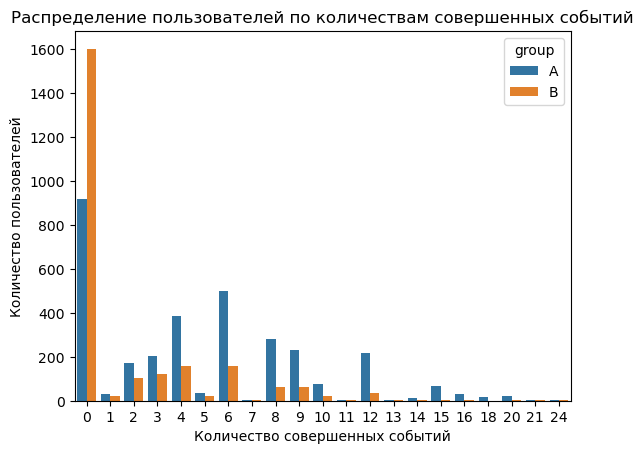

In [40]:
sns.barplot(data=group_event, x="event_name", y="user_id", hue="group")
plt.xlabel("Количество совершенных событий")
plt.ylabel("Количество пользователей")
plt.title ("Распределение пользователей по количествам совершенных событий");

Из графика видно, что многие пользователи не совершили ни одного события. Уберем этих пользователей из графика и посмотрим, как распределены пользователи.

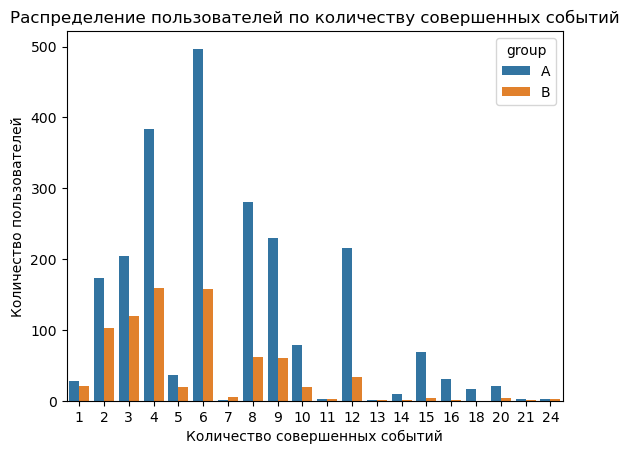

In [41]:
sns.barplot(data=group_event.query('event_name!=0'), x="event_name", y="user_id", hue="group")
plt.xlabel("Количество совершенных событий")
plt.ylabel("Количество пользователей")
plt.title ("Распределение пользователей по количеству совершенных событий")
plt.show;


В группе А пик событий на 6, а затем происходит спад, а у группы В пик приходится на 4 и 6 событий, затем происходит зезкий спад.

Определим, сколько событий в реднем приходится на пользователей, которые совершали какие-либо действия.

In [42]:
# создадим df без пропусков в столбцах event_dt и event_name 
df_no_nan = df_new.dropna(subset=['event_name'])
df_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20034 entries, 0 to 26289
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     20034 non-null  object        
 1   group       20034 non-null  object        
 2   ab_test     20034 non-null  object        
 3   first_date  20034 non-null  datetime64[ns]
 4   region      20034 non-null  object        
 5   device      20034 non-null  object        
 6   event_dt    20034 non-null  datetime64[ns]
 7   event_name  20034 non-null  object        
 8   details     2736 non-null   float64       
 9   lifetime    20034 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 1.7+ MB


In [43]:
# количество сообытий по пользователям, которые совершали действия
ab_events1 = (df_no_nan.pivot_table(index='group', aggfunc={'event_dt': 'count', 'user_id': 'nunique'})
             .rename(columns = {'event_dt': 'count_events', 'user_id': 'qty_users'}))

# определим количество событий на каждого пользователя в группах
ab_events1['events_per_user'] = round(ab_events1['count_events'] / ab_events1['qty_users'], 2)

ab_events1

,count_events,qty_users,events_per_user
group,,,
A,15851,2279,6.96
B,4183,771,5.43


Полученные данные значительно отличаются от среднего кол-ва действий на уникального пользователя. В среднем, на участника группы А приходится 6.96 события, в группе В - 5.43 события.

## 4.2 **Распределение числа событий в выборках по дням**

Рассмотрим, как события распределены по дням.

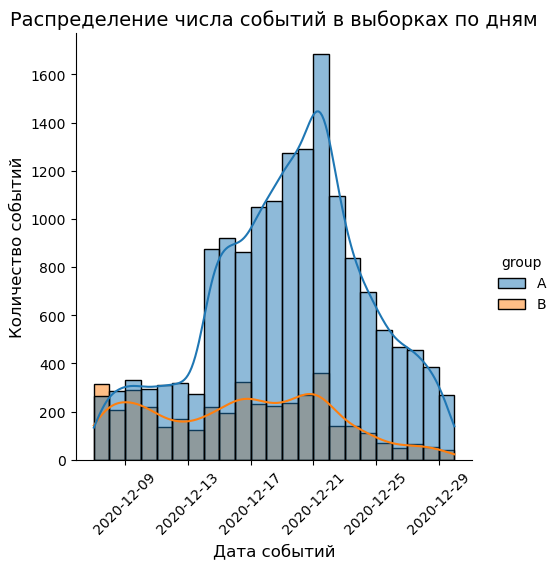

In [44]:
# Распределение числа событий в выборках по дням
sns.displot(data=df_new, x='event_dt', kde=True, bins=23, hue = 'group', common_norm=False)
plt.title(label = "Распределение числа событий в выборках по дням", fontsize = 14)
plt.ylabel('Количество событий',  fontsize = 12)
plt.xlabel('Дата событий', size = 12)
plt.xticks(rotation=45)
plt.show();

В самом начале теста событий в группе В происходило больше, но затем наметился явный перекос в пользу группы А.
- наблюдается резкий рост числа событий в группе А в период с 14 декабря.
- количество событий в группе А максимально 21 декабря, затем начинается спад.
- с 22 декабря спад активности в обоих группах. Возможно это связано с окончанием набора новых пользователей и снижением активности оставшихся.
- группа В имеет более равномерное распределение, без резких всплесков, в отличии от группы А, но с гораздо меньшей активностью пользователей.
- после 30 декабря вообще не зафиксировано ни одного события ни для одной из групп.

Рассмотрим, как распределено привлечение пользователей, по дате их регистрации

In [45]:
# сводная таблица с кол-вом зарегистрированных в день
reg = (df_new.groupby(['first_date','group'], as_index=False)['user_id'].nunique()
                            .rename(columns={'user_id':'users_count'}))
reg

,first_date,group,users_count
0,2020-12-07,A,303
1,2020-12-07,B,218
2,2020-12-08,A,164
3,2020-12-08,B,124
4,2020-12-09,A,122
5,2020-12-09,B,90
6,2020-12-10,A,161
7,2020-12-10,B,163
8,2020-12-11,A,137
9,2020-12-11,B,96


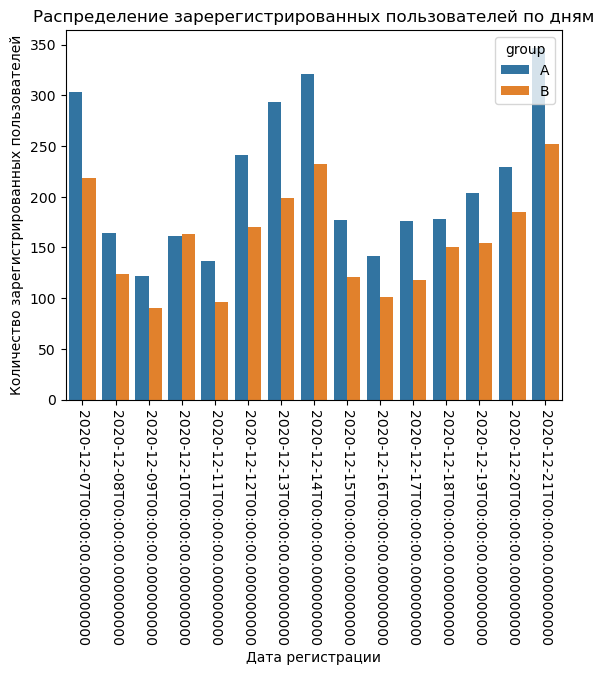

In [46]:
sns.barplot(data=reg, x="first_date", y="users_count", hue="group")
plt.xlabel("Дата регистрации")
plt.ylabel("Количество зарегистрированных пользователей")
plt.title ("Распределение заререгистрированных пользователей по дням")
plt.xticks(rotation=-90)
plt.show;


Пользователи, участвующие в тесте регистрировались неравномерно. Количество зарегистрированных в группе А больше, чем в группе В, но динамика их набора в тестовые группы совпадает. Всплески набора пользователей наблюдаются 7.12, 12.12-14.12 и 21.12.

Всплеск событий в группе А 21 декабря можно объяснить действиями пользователей, зарегистрированными до этой даты и активной регистрацией новых пользователей в этот день.

## 4.3 **Изменения конверсии в воронке в выборках на разных этапах**

Построим продуктовую воронку и рассмотрим показатели конверсии.

In [47]:
# cводная таблица событий по группам 
funnel_event = (df_new.pivot_table(index='event_name', 
                             columns='group', 
                             values='user_id',
                             aggfunc='nunique')
                             .reindex(['login', 'product_page', 'product_cart', 'purchase']))  #ранжирование воронки
funnel_event

group,A,B
event_name,,
login,2279,770
product_page,1476,429
product_cart,686,214
purchase,734,219


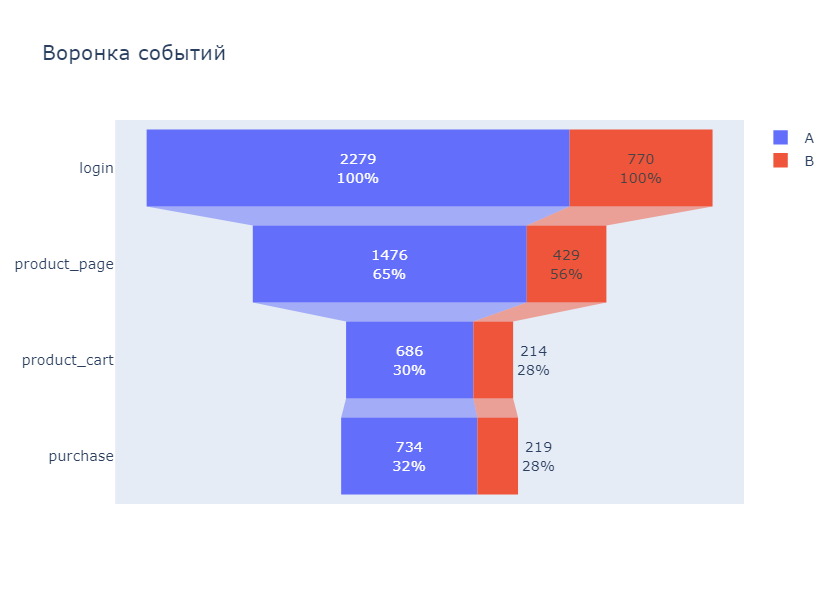

In [48]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = funnel_event.index.tolist(),
    x = funnel_event['A'].tolist(),
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = funnel_event.index.tolist(),
    x = funnel_event['B'].tolist(),
    #textposition = "inside",
    textinfo = "value+percent initial"))
fig.update_layout(title="Воронка событий")
fig.show("png")

**Анализ воронки событий.**

- Конверсия в группе В 28%, что ниже, чем в контрольной группе А (32%).
- Конверсия значительно падает при переходе с этапа 'login' к 'product_page'. Только 65% участников группы А и 56% участников группы В просматривают страницы товаров.
- Просмотр корзины товаров 'product_cart' не является обязательным этапом 'жизни пользователя'.
- До этапа покупки доходит лишь 32% участников группы А и 28% участников группы В.

Согласно ТЗ "ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%". По результатам анализа проведенного теста выявлено, что конверсия в группе В упала в сравнении с контрольной.
Скорее всего, эксперимент можно признать неудачным.

## 4.4 **Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию**

1. Деление трафика на группы А и B не равномерно, результаты теста могут быть искажены.

2. Тест закончен до заявленного в ТЗ срока 2021-01-04, а именно 2020-12-29, могут присутствовать пользователи с лайфтаймом менее 14 дней.

3. Есть отклонения в численности участников теста: по результатам фильтрации в тесте остались 5568 человек, из которых 57.38% попали в группу А, 42.62% - в группу В, доля пользователей из Европы, участвующих в тесте составила 12.03 %.

4. Распределение набора пользователей в группы и их действия распределены неравномерно. На графиках обнаружен скачок в поведении пользователей. 

5. Есть пересечение пользователей теста recommender_system_test и конкурирующего теста interface_eu_test, нельзя с точностью сказать, что повлияло на поведение контрольной группы пользователей.

6. Время проведения теста выбранно некорректрое. Тест проводился во время предновогодней маркетинговой компании, это может привести к некорректному результату. Делать А/Б тест во время аномального поведения пользователей может привести к некорректному результату, и статистическая значимость будет достигнута из-за аномальных колебаний, а не из-за изменений в продукте.


# 5. **Оценка результатов A/B-тестирования**
## 5.1 **Какие результаты показало A/В-тестирование**

Проведенное АВ тестирование показало, что конверсия на каждом этапе воронки в группе В ниже, чем в контрольной. К этим результатам нужно относиться с осторожностью, т.к. были вывявлены ошибки в наборе пользователей и во времени проведения теста.

## 5.2 **Проверка статистической разницы долей z-критерием**

Проверим, имеется ли у нас статистически значимая разница в конверсии между группами.

Ввиду того, что будем проводить множественный тест нужно использовать поправку к уровню значимостиПроверок немного, то можно обойтись поправкой Бонферрони.

Н0 - между долями статистически значимая разница отсутствует

Н1 - между долями есть статистически значимая разница

In [49]:
funnel_event=funnel_event.T
funnel_event

event_name,login,product_page,product_cart,purchase
group,,,,
A,2279,1476,686,734
B,770,429,214,219


In [50]:
alpha = 0.05/3
stat, pval = proportions_ztest(count= funnel_event['product_page'], nobs= funnel_event['login'])

print('Проверка гипотезы о различиях в долях конверсии по событию product_page в группах A и B')
print(pval)
if pval < alpha:
    print("Отвергаем нулевую гипотезу: между долями есть статистически значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


Проверка гипотезы о различиях в долях конверсии по событию product_page в группах A и B
7.302688278207464e-06
Отвергаем нулевую гипотезу: между долями есть статистически значимая разница


In [51]:
stat, pval = proportions_ztest(count= funnel_event['product_cart'], nobs= funnel_event['login'])
print(funnel_event['product_cart'], funnel_event['login'])
print('Проверка гипотезы о различиях в долях конверсии по событию product_cart в группах A и B')
print(pval)
if pval < alpha:
    print("Отвергаем нулевую гипотезу: между долями есть статистически значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


group
A    686
B    214
Name: product_cart, dtype: int64 group
A    2279
B     770
Name: login, dtype: int64
Проверка гипотезы о различиях в долях конверсии по событию product_cart в группах A и B
0.22463227493216675
Не получилось отвергнуть нулевую гипотезу


In [52]:
stat, pval = proportions_ztest(count= funnel_event['purchase'], nobs= funnel_event['login'])
print('Проверка гипотезы о различиях в долях конверсии по событию purchase в группах A и B')
print(pval)
if pval < alpha:
    print("Отвергаем нулевую гипотезу: между долями есть статистически значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


Проверка гипотезы о различиях в долях конверсии по событию purchase в группах A и B
0.051311118141838426
Не получилось отвергнуть нулевую гипотезу


In [53]:
#alpha = 0.05/3
#col = ['product_page', 'product_cart', 'purchase']
#for i in col:
#    stat, pval = proportions_ztest(count= funnel_event[i], nobs= funnel_event['login'])
#    print('Проверка гипотезы о различиях в долях конверсии по событию', funnel_event.columns[i], 'в группах A и B')
#    print(pval)
#    if pval < alpha:
#        print("Отвергаем нулевую гипотезу: между долями есть статистически значимая разница")
#    else:
#        print("Не получилось отвергнуть нулевую гипотезу") 
#    print()

Статистически значимую между долями обнаружена только в конверсии событии product_page. На остальных этапах конверсии статистически значимая разница в долях пользователей, совершавших событие отсутствует.

# 6. **Вывод, общее заключение о корректности проведения теста**

Цель исследования — провести оценку результатов A/B-теста, оценить корректность его проведения, проанализировать результаты теста.

Для исследования было предоставлено 4 файла с табличной информацией. В данных дубликатов, ошибок, аномальных значений, пропусков (кроме столбца details) не было.

Но, в ходе анализа представленных данных было выяснено, что данные не соответствуют требованиям технического задания.
По результатам оценки корректности проведения теста, его совпадению с ТЗ выявлено:
- сроки набора новых пользователей в группы теста совпадают с ТЗ.
- тест закончен до заявленного в ТЗ срока 2021-01-04, а именно 2020-12-29, могут присутствовать пользователи с лайфтаймом менее 14 дней. 
- есть отклонения в численности участников теста: по результатам фильтрации в тесте остались 5568 человек, из которых 57.38% попали в группу А, 42.62% - в группу В, доля пользователей из Европы, участвующих в тесте составила 9.02 %.
- время проведения теста совпадает с новогодней маркетинговой акцией. В этот момент возможно аномальное поведение пользователей.
- есть пересечение пользователей теста recommender_system_test и конкурирующего теста interface_eu_test, нельзя с точностью сказать, что повлияло на поведение контрольной группы пользователей.

Была проведена проверка статистическую разницу долей z-критерием. Только по одному типу события - product_pages между долями в группах есть статистически значимая разница. На остальных этапах статистически значимая разница между долями отсутствует.

Ожидаемый прирост конверсии в 10% по переходам не достигнут.

С учетом описанных выше проблем и ошибок при проведении АВ тестирования не следует с доверием относиться к результатам теста и использовать его для принятия дальнейших решений.

Я бы рекомендовала провести заново, т.к. тест остановлен на 5 дней раньше, и мы можем наткнуться на "проблему подглядывания". При проведении нового теста следует учесть и устранить все выявленные недоработки. Необходимо будет тщательней отбирать участников и отслеживать из действия в течение всего срока проведения теста. А еще, не запускать тест в период предновогодних праздников. Ведь негативный результат мог получиться и по причине того, что пользователь быстро найти и заказать подарок накануне Рождества, но натыкается на нестандартный дизайн сайта и уходит.